Price           Close                                                          \
Ticker           AAPL       AMZN      GOOGL        META        MSFT      NVDA   
Date                                                                            
2020-01-02  72.538536  94.900497  68.026016  208.635391  152.791092  5.971748   
2020-01-03  71.833275  93.748497  67.670166  207.531464  150.888657  5.876163   
2020-01-06  72.405670  95.143997  69.473846  211.440033  151.278625  5.900806   
2020-01-07  72.065147  95.343002  69.339645  211.897507  149.899307  5.972245   
2020-01-08  73.224411  94.598503  69.833191  214.045746  152.286957  5.983446   

Price            High                                    ...       Open  \
Ticker           AAPL       AMZN      GOOGL        META  ...      GOOGL   
Date                                                     ...              
2020-01-02  72.598914  94.900497  68.026016  208.645331  ...  67.018562   
2020-01-03  72.594040  94.309998  68.278024  209.25

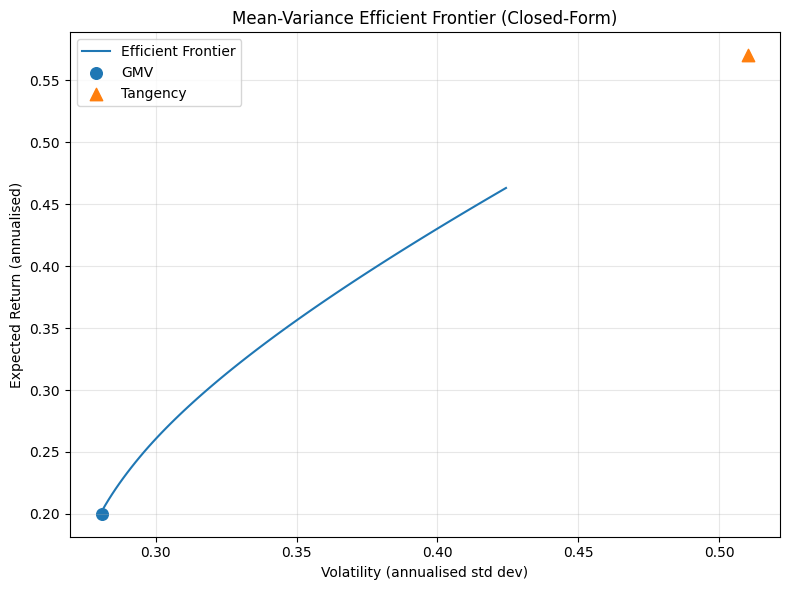

In [ ]:
"""
Mean-Variance Optimisation (MVO) from scratch in Python
------------------------------------------------------

What this script does:
1) Downloads daily adjusted-close prices for a few large-cap stocks from Yahoo Finance
2) Computes log returns, annualised mean returns and covariance matrix
3) Builds MVO portfolios *from scratch* using closed-form linear algebra (no external optimisers):
   - Global Minimum Variance (GMV) portfolio
   - Efficient frontier portfolios for a grid of target returns
   - Tangency (maximum Sharpe) portfolio with a user-set risk-free rate
4) (Optional) Applies a basic long-only projection heuristic (not strictly optimal) to get non-negative weights
5) Plots the efficient frontier and highlights GMV and Tangency portfolios

Requirements:
- pip install yfinance numpy pandas matplotlib

Notes:
- The closed-form solutions assume full invertibility of the covariance matrix.
- The long-only projection used here is a simple heuristic; exact long-only MVO is a QP with inequality constraints.
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 1) USER SETTINGS
# ----------------------------
# Choose a handful of well-traded companies (feel free to edit)
TICKERS = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META"]

# Date range for historical data
START = "2020-01-01"
END   = None  # None -> up to today

# Risk-free rate (annual). Example: 0.02 for 2%.
RF = 0.02

# Whether to apply a simple long-only projection heuristic to weights
LONG_ONLY = False

# ----------------------------
# 2) DATA DOWNLOAD & PREP
# ----------------------------
# Download Adjusted Close to account for splits/dividends
px = yf.download(TICKERS, start=START, end=END, progress=False)

# If downloading multiple tickers, the columns are multi-level. Select the 'Adj Close' level.
if len(TICKERS) > 1:
    px = px['Close']

px = px.dropna(how="all")

# Drop columns with too many NaNs and forward-fill small gaps
px = px.dropna(axis=1, how="any")

# Compute daily log returns: r_t = ln(P_t / P_{t-1})
# Using log returns makes aggregation additive over time
ret = np.log(px / px.shift(1)).dropna()

# Annualisation factors: ~252 trading days
TRADING_DAYS = 252

# Annualised mean returns (drift) via arithmetic mean of daily log returns
# Approximating annual expected return by multiplying average daily log return by 252
mu = ret.mean() * TRADING_DAYS  # (n,)

# Annualised covariance matrix of daily log returns
Sigma = ret.cov() * TRADING_DAYS  # (n x n)

# Convert to NumPy arrays for linear algebra
mu_v = mu.values.reshape(-1, 1)                    # (n,1)
Sigma_m = Sigma.values                              # (n,n)
ones = np.ones((len(mu), 1))

# Sanity check: ensure Sigma is positive definite (or make it numerically stable)
# Add a tiny ridge if needed (helps invertibility without changing results much)
EPS = 1e-8
Sigma_m += EPS * np.eye(Sigma_m.shape[0])

# Pre-compute the inverse once
Sigma_inv = np.linalg.inv(Sigma_m)

# Pre-compute key scalars for closed-form solutions
A = float(ones.T @ Sigma_inv @ ones)           # 1^T Σ^{-1} 1
B = float(ones.T @ Sigma_inv @ mu_v)           # 1^T Σ^{-1} μ
C = float(mu_v.T @ Sigma_inv @ mu_v)           # μ^T Σ^{-1} μ
D = A * C - B**2                               # Determinant-like term

# ----------------------------
# 3) CLOSED-FORM PORTFOLIOS
# ----------------------------

def weights_gmv():
    """Global Minimum Variance portfolio (no target return), closed-form.

    w_gmv = Σ^{-1} 1 / (1^T Σ^{-1} 1)
    """
    w = (Sigma_inv @ ones) / A
    return w.flatten()


def weights_target_return(mu_star):
    """Efficient frontier weights for a given target return μ*.

    w(μ*) = Σ^{-1} [ ((C - μ* B)/D) 1 + ((μ* A - B)/D) μ ]
    Ensures 1^T w = 1 and w^T μ = μ*.
    """
    term1 = ((C - mu_star * B) / D) * ones
    term2 = ((mu_star * A - B) / D) * mu_v
    w = Sigma_inv @ (term1 + term2)
    return w.flatten()


def weights_tangency(rf=0.0):
    """Tangency portfolio weights (maximum Sharpe) with risk-free rate rf.

    Proportional to Σ^{-1} (μ - rf 1), then normalised to sum to 1.
    """
    excess = mu_v - rf * ones
    w_unnorm = Sigma_inv @ excess
    w = w_unnorm / float(ones.T @ w_unnorm)
    return w.flatten()

# Basic (non-optimal) long-only projection heuristic: set negatives to 0 and renormalise
# Note: This is *not* the exact solution to the long-only MVO; it's just a quick fix.

def project_long_only(w):
    w = np.maximum(w, 0)
    s = w.sum()
    if s <= 0:
        # if everything was negative, fall back to equal-weight
        w = np.ones_like(w) / len(w)
    else:
        w = w / s
    return w

# ----------------------------
# 4) BUILD PORTFOLIOS
# ----------------------------
# Global Minimum Variance
w_gmv = weights_gmv()
if LONG_ONLY:
    w_gmv = project_long_only(w_gmv)

# Tangency (Max Sharpe)
w_tan = weights_tangency(RF)
if LONG_ONLY:
    w_tan = project_long_only(w_tan)

# Efficient frontier: choose a grid of target returns between min and max of expected returns
mu_min, mu_max = float(mu.min()), float(mu.max())
mu_grid = np.linspace(mu_min, mu_max, 100)
weights_grid = np.vstack([weights_target_return(m) for m in mu_grid])
if LONG_ONLY:
    weights_grid = np.vstack([project_long_only(w) for w in weights_grid])

# Compute (risk, return) for frontier portfolios
def portfolio_stats(w):
    w = w.reshape(-1, 1)
    r = float(w.T @ mu_v)
    v = float(w.T @ Sigma_m @ w)
    s = np.sqrt(v)
    return r, s

frontier = np.array([portfolio_stats(w) for w in weights_grid])  # shape: (100, 2) -> (return, stdev)

# GMV stats
r_gmv, s_gmv = portfolio_stats(w_gmv)
# Tangency stats
r_tan, s_tan = portfolio_stats(w_tan)
sh_tan = (r_tan - RF) / s_tan if s_tan > 0 else np.nan

# ----------------------------
# 5) REPORT RESULTS
# ----------------------------
print("=== Mean-Variance Optimisation (from scratch) ===")
print(f"Tickers: {list(mu.index)}")
print(f"Sample length: {ret.shape[0]} daily observations")
print(f"Risk-free (annual): {RF:.2%}")
print()

print("Expected returns (annual, log-return approx):")
for t, m in mu.items():
    print(f"  {t:5s}: {m: .2%}")
print()

print("GMV weights:")
for t, w in zip(mu.index, w_gmv):
    print(f"  {t:5s}: {w: .2%}")
print(f"GMV -> Return: {r_gmv:.2%}, Volatility: {s_gmv:.2%}")
print()

print("Tangency (max Sharpe) weights:")
for t, w in zip(mu.index, w_tan):
    print(f"  {t:5s}: {w: .2%}")
print(f"Tangency -> Return: {r_tan:.2%}, Volatility: {s_tan:.2%}, Sharpe: {sh_tan:.2f}")

# ----------------------------
# 6) PLOT FRONTIER
# ----------------------------
plt.figure(figsize=(8, 6))
# Frontier cloud: x = volatility, y = expected return
plt.plot(frontier[:, 1], frontier[:, 0], label="Efficient Frontier")
# Mark GMV and Tangency
plt.scatter([s_gmv], [r_gmv], marker="o", s=70, label="GMV")
plt.scatter([s_tan], [r_tan], marker="^", s=80, label="Tangency")
plt.xlabel("Volatility (annualised std dev)")
plt.ylabel("Expected Return (annualised)")
plt.title("Mean-Variance Efficient Frontier (Closed-Form)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 7) HOW TO USE
# ----------------------------
# - Run this script as-is. Edit TICKERS/START/END/RF/LONG_ONLY at the top to experiment.
# - For truly long-only optimal weights, use a QP solver (e.g., cvxopt/cvxpy),
#   but here we keep it "from scratch" by showing closed-form equality-constrained solutions.

=== Mean-Variance Optimisation (with Long-Only QP) ===
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA']
Risk-free (annual): 2.00%

Expected returns (annual):
  AAPL :  20.35%
  AMZN :  15.65%
  GOOGL:  19.71%
  META :  22.87%
  MSFT :  21.34%
  NVDA :  60.37%

GMV (long-only) weights:
  AAPL :  27.25%
  AMZN :  10.06%
  GOOGL:  23.75%
  META : -0.00%
  MSFT :  38.94%
  NVDA : -0.00%
GMV -> Return: 20.11%, Volatility: 28.09%

Tangency (long-only) weights:
  AAPL : -0.00%
  AMZN : -0.00%
  GOOGL: -0.00%
  META : -0.00%
  MSFT : -0.00%
  NVDA :  100.00%
Tangency -> Return: 60.37%, Volatility: 53.85%, Sharpe: 1.08


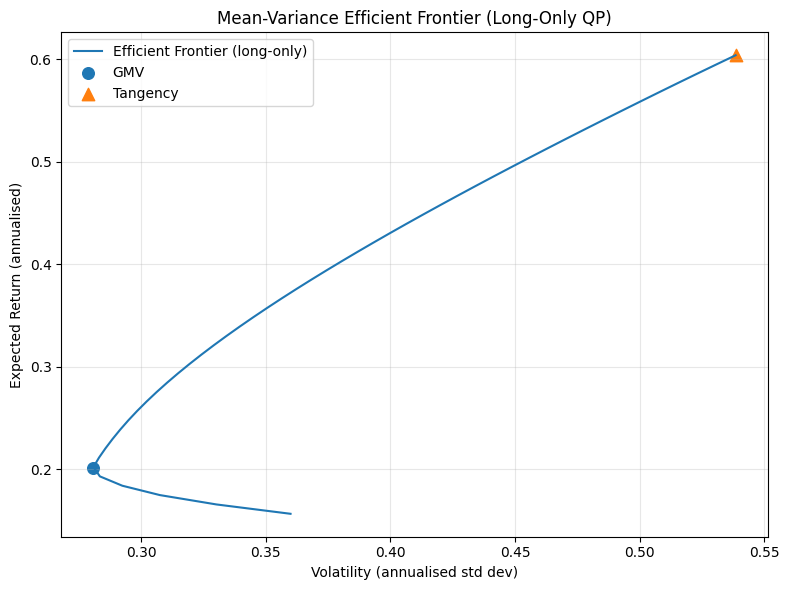

=== Exact Long-Only MVO (cvxpy) ===
GMV (long-only) weights:
  AAPL :  27.25%
  AMZN :  10.06%
  GOOGL:  23.75%
  META :  0.00%
  MSFT :  38.94%
  NVDA :  0.00%
GMV (LO) -> Return: 20.11%, Volatility: 28.09%
Tangency (approx via frontier sweep, long-only) weights:
  AAPL :  0.00%
  AMZN : -0.00%
  GOOGL:  0.00%
  META :  0.00%
  MSFT :  0.00%
  NVDA :  100.00%
Tangency (LO) -> Return: 60.37%, Volatility: 53.85%, Sharpe: 1.08


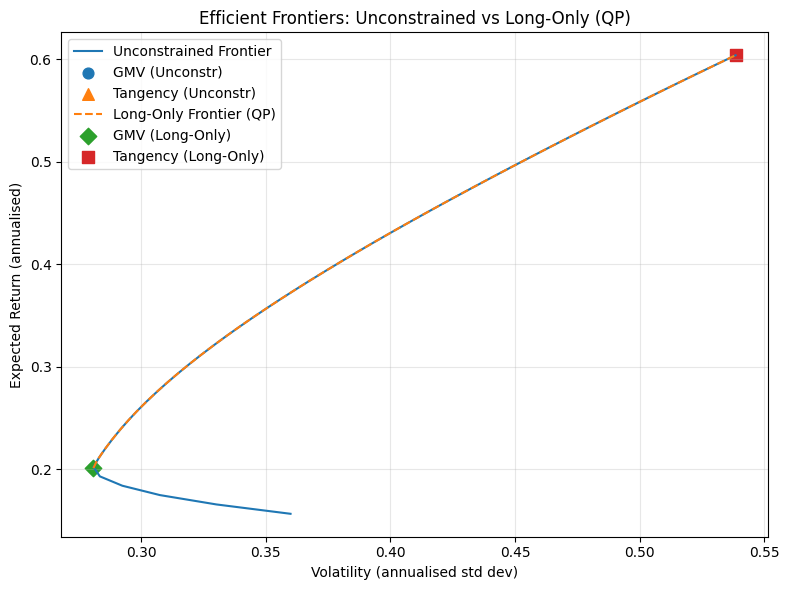

In [ ]:
"""
Mean-Variance Optimisation (MVO) with exact Long-Only solution via Quadratic Programming
------------------------------------------------------

What this script does:
1) Downloads daily adjusted-close prices for a few large-cap stocks from Yahoo Finance
2) Computes log returns, annualised mean returns and covariance matrix
3) Builds MVO portfolios:
   - Global Minimum Variance (GMV) portfolio (closed-form and QP long-only)
   - Efficient frontier portfolios for a grid of target returns (QP long-only)
   - Tangency (maximum Sharpe) portfolio with a user-set risk-free rate (QP long-only)
4) Plots the efficient frontier and highlights GMV and Tangency portfolios

Requirements:
- pip install yfinance numpy pandas matplotlib cvxpy

Notes:
- Closed-form solutions are included (without long-only constraint).
- QP solver enforces w_i ≥ 0 (long-only portfolios).
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp

# ----------------------------
# 1) USER SETTINGS
# ----------------------------
TICKERS = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META"]
START = "2020-01-01"
END   = None
RF = 0.02   # annual risk-free rate

# ----------------------------
# 2) DATA DOWNLOAD & PREP
# ----------------------------
px = yf.download(TICKERS, start=START, end=END, progress=False)["Close"].dropna(how="all")
px = px.dropna(axis=1, how="any")
ret = np.log(px / px.shift(1)).dropna()

TRADING_DAYS = 252
mu = ret.mean() * TRADING_DAYS
Sigma = ret.cov() * TRADING_DAYS

mu_v = mu.values.reshape(-1, 1)
Sigma_m = Sigma.values
ones = np.ones((len(mu), 1))

# Regularise covariance for invertibility
EPS = 1e-8
Sigma_m += EPS * np.eye(Sigma_m.shape[0])

# ----------------------------
# 3) CLOSED-FORM GMV + TANGENCY (NO CONSTRAINTS)
# ----------------------------
Sigma_inv = np.linalg.inv(Sigma_m)
A = float(ones.T @ Sigma_inv @ ones)
B = float(ones.T @ Sigma_inv @ mu_v)
C = float(mu_v.T @ Sigma_inv @ mu_v)
D = A * C - B**2

def weights_gmv_closed():
    return (Sigma_inv @ ones / A).flatten()

def weights_tangency_closed(rf=0.0):
    excess = mu_v - rf * ones
    w = Sigma_inv @ excess
    return (w / float(ones.T @ w)).flatten()

# ----------------------------
# 4) QP SOLVERS (EXACT LONG-ONLY)
# ----------------------------

def qp_optimize(target_ret=None, rf=None):
    """
    Solve:
        min w^T Σ w
    subject to:
        sum(w) = 1
        w >= 0
        if target_ret is not None: w^T μ = target_ret
        if rf is not None: maximize Sharpe ratio (equivalent to max (μ-rf)/σ)
    """
    n = len(mu)
    w = cp.Variable(n)

    # Objective: minimise variance
    risk = cp.quad_form(w, Sigma_m)

    constraints = [cp.sum(w) == 1, w >= 0]

    if target_ret is not None:
        constraints.append(w @ mu.values == target_ret)
        prob = cp.Problem(cp.Minimize(risk), constraints)
        prob.solve()
        return np.array(w.value).flatten()

    elif rf is not None:
        # Max Sharpe: maximise (μ - rf)^T w / sqrt(w^T Σ w)
        excess = mu.values - rf
        # Equivalent: maximise (μ-rf)^T w, subject to variance <= 1, w >=0, sum(w)=1
        ret_expr = excess @ w
        prob = cp.Problem(cp.Maximize(ret_expr), constraints + [cp.quad_form(w, Sigma_m) <= 1])
        prob.solve()
        return np.array(w.value).flatten()

    else:
        prob = cp.Problem(cp.Minimize(risk), constraints)
        prob.solve()
        return np.array(w.value).flatten()

# ----------------------------
# 5) BUILD PORTFOLIOS
# ----------------------------
# GMV (long-only)
w_gmv = qp_optimize()

# Tangency (long-only)
w_tan = qp_optimize(rf=RF)

# Efficient frontier (long-only): vary target return
mu_min, mu_max = float(mu.min()), float(mu.max())
mu_grid = np.linspace(mu_min, mu_max, 50)
weights_grid = [qp_optimize(target_ret=m) for m in mu_grid]

# ----------------------------
# 6) PORTFOLIO STATS
# ----------------------------

def portfolio_stats(w):
    w = w.reshape(-1, 1)
    r = float(w.T @ mu_v)
    v = float(w.T @ Sigma_m @ w)
    s = np.sqrt(v)
    return r, s

frontier = np.array([portfolio_stats(w) for w in weights_grid])
r_gmv, s_gmv = portfolio_stats(w_gmv)
r_tan, s_tan = portfolio_stats(w_tan)
sh_tan = (r_tan - RF) / s_tan if s_tan > 0 else np.nan

# ----------------------------
# 7) REPORT
# ----------------------------
print("=== Mean-Variance Optimisation (with Long-Only QP) ===")
print(f"Tickers: {list(mu.index)}")
print(f"Risk-free (annual): {RF:.2%}\n")

print("Expected returns (annual):")
for t, m in mu.items():
    print(f"  {t:5s}: {m: .2%}")
print()

print("GMV (long-only) weights:")
for t, w in zip(mu.index, w_gmv):
    print(f"  {t:5s}: {w: .2%}")
print(f"GMV -> Return: {r_gmv:.2%}, Volatility: {s_gmv:.2%}\n")

print("Tangency (long-only) weights:")
for t, w in zip(mu.index, w_tan):
    print(f"  {t:5s}: {w: .2%}")
print(f"Tangency -> Return: {r_tan:.2%}, Volatility: {s_tan:.2%}, Sharpe: {sh_tan:.2f}")

# ----------------------------
# 8) PLOT FRONTIER
# ----------------------------
plt.figure(figsize=(8, 6))
plt.plot(frontier[:, 1], frontier[:, 0], label="Efficient Frontier (long-only)")
plt.scatter([s_gmv], [r_gmv], marker="o", s=70, label="GMV")
plt.scatter([s_tan], [r_tan], marker="^", s=80, label="Tangency")
plt.xlabel("Volatility (annualised std dev)")
plt.ylabel("Expected Return (annualised)")
plt.title("Mean-Variance Efficient Frontier (Long-Only QP)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ----------------------------
# 7a) EXACT LONG-ONLY (INEQUALITY-CONSTRAINED) MVO VIA CVXPY
# ----------------------------
# This section solves the *true* long-only problem using Quadratic Programming.
#   minimise   w^T Σ w
#   subject to 1^T w = 1, w >= 0   (and optionally w^T μ = μ*)
# For the tangency portfolio, we sweep a grid of target returns and choose the
# one with the highest Sharpe among feasible long-only solutions.

try:
    #!pip install cvxpy
    !pip install ECOS
    import cvxpy as cp


    def qp_long_only_gmv(S):
        """True long-only Global Minimum Variance portfolio.
        minimise w^T S w  s.t. 1^T w = 1, w >= 0
        """
        n = S.shape[0]
        w = cp.Variable(n)
        obj = cp.Minimize(cp.quad_form(w, S))
        cons = [cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(obj, cons)
        prob.solve(solver=cp.ECOS, verbose=False)
        return np.array(w.value).flatten()

    def qp_long_only_target(S, mu_vec, mu_star):
        """True long-only efficient frontier point at target return mu_star.
        minimise w^T S w  s.t. 1^T w = 1, w >= 0, w^T mu = mu_star
        Returns weights or None if infeasible for that target.
        """
        n = S.shape[0]
        w = cp.Variable(n)
        obj = cp.Minimize(cp.quad_form(w, S))
        cons = [cp.sum(w) == 1, w >= 0, mu_vec @ w == mu_star]
        prob = cp.Problem(obj, cons)
        try:
            prob.solve(solver=cp.ECOS, verbose=False)
        except Exception:
            return None
        if w.value is None:
            return None
        return np.array(w.value).flatten()

    # Compute exact long-only GMV
    w_gmv_lo = qp_long_only_gmv(Sigma_m)
    r_gmv_lo, s_gmv_lo = portfolio_stats(w_gmv_lo)

    # Exact long-only efficient frontier over a feasible grid of returns
    # Start from slightly above the minimum achievable return and below the max
    # feasible long-only return.
    r_min = float((w_gmv_lo.reshape(-1,1).T @ mu_v).ravel())
    r_max = float(mu.max())  # upper bound of target grid
    mu_grid_lo = np.linspace(max(mu_min, r_min), r_max, 60)

    W_lo = []
    for mstar in mu_grid_lo:
        w_star = qp_long_only_target(Sigma_m, mu.values, mstar)
        if w_star is not None:
            W_lo.append(w_star)
        else:
            W_lo.append(np.full(len(mu), np.nan))
    W_lo = np.vstack(W_lo)

    # Filter feasible points
    feas_mask = ~np.isnan(W_lo).any(axis=1)
    front_lo = np.array([portfolio_stats(w) for w in W_lo[feas_mask]]) if feas_mask.any() else np.empty((0,2))

    # Long-only "tangency": pick feasible target with highest Sharpe
    sh_tan_lo, r_tan_lo, s_tan_lo, w_tan_lo = (np.nan, np.nan, np.nan, None)
    if front_lo.shape[0] > 0:
        excess = front_lo[:,0] - RF
        vol = front_lo[:,1]
        sharpe = np.divide(excess, vol, out=np.full_like(excess, np.nan), where=vol>0)
        idx = np.nanargmax(sharpe)
        sh_tan_lo = sharpe[idx]
        r_tan_lo, s_tan_lo = front_lo[idx]
        w_tan_lo = W_lo[feas_mask][idx]

    # Print exact long-only results
    print("=== Exact Long-Only MVO (cvxpy) ===")
    print("GMV (long-only) weights:")
    for t, w in zip(mu.index, w_gmv_lo):
        print(f"  {t:5s}: {w: .2%}")
    print(f"GMV (LO) -> Return: {r_gmv_lo:.2%}, Volatility: {s_gmv_lo:.2%}")

    if w_tan_lo is not None:
        print("Tangency (approx via frontier sweep, long-only) weights:")
        for t, w in zip(mu.index, w_tan_lo):
            print(f"  {t:5s}: {w: .2%}")
        print(f"Tangency (LO) -> Return: {r_tan_lo:.2%}, Volatility: {s_tan_lo:.2%}, Sharpe: {sh_tan_lo:.2f}")
    else:
        print("Tangency (LO): No feasible frontier points found on grid.")

    # Plot: overlay exact long-only frontier
    if front_lo.shape[0] > 0:
        plt.figure(figsize=(8, 6))
        # Closed-form (unconstrained) frontier
        plt.plot(frontier[:, 1], frontier[:, 0], label="Unconstrained Frontier")
        plt.scatter([s_gmv], [r_gmv], marker="o", s=60, label="GMV (Unconstr)")
        plt.scatter([s_tan], [r_tan], marker="^", s=70, label="Tangency (Unconstr)")
        # Exact long-only frontier
        plt.plot(front_lo[:, 1], front_lo[:, 0], linestyle="--", label="Long-Only Frontier (QP)")
        plt.scatter([s_gmv_lo], [r_gmv_lo], marker="D", s=70, label="GMV (Long-Only)")
        if w_tan_lo is not None:
            plt.scatter([s_tan_lo], [r_tan_lo], marker="s", s=80, label="Tangency (Long-Only)")
        plt.xlabel("Volatility (annualised std dev)")
        plt.ylabel("Expected Return (annualised)")
        plt.title("Efficient Frontiers: Unconstrained vs Long-Only (QP)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

except ImportError:
  print("Install cvpxy")


In [ ]:
!pip install --upgrade cvxpy[ecos]